In [1]:
import os
import re
from skimage import io, color
from skimage.color import rgb2gray
from skimage.io import imread

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import plot_model
from keras.callbacks import History 


Using TensorFlow backend.


In [2]:
'''
define import_images function to pull from directory, convert to grayscale, append to list
'''
def import_images(dir_name, images, image_names):
    for root, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                image_names.append(filename)
                
                ## read images and add to list
                image = io.imread(fname=filepath)
                image_gray = rgb2gray(image)
                images.append(image_gray)


In [3]:
'''
establish expected image parameters, training, validation locations
'''

# expected image size
img_width, img_height = 512, 512

# folder containing the images on which the network will train. The train folder 
# has two sub folders, 'yes' and 'no' needle-containing images.
train_data_dir = '../../data_culled/train'

# folder containing the validation samples folder structure is same as the training folder
validation_data_dir = '../../data_culled/validation'

# how many images to be considered for training
train_images = []
train_names = []
import_images(train_data_dir, train_images, train_names)
train_samples = len(train_images)
print(train_samples)

# how many images to be used for validation
validation_images = []
validation_names = []
import_images(validation_data_dir, validation_images, validation_names)
validation_samples = len(validation_images)
print(validation_samples)

# set batch size
batch_size = 32

# how many runs will the network make over the training set before starting on validation
epoch = 100


1200
38


In [4]:
'''
run image augmentation procedures
'''

# augmentation configuration for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip = True)

# augmentation configuration for testing:
    # only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 1200 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


In [5]:
'''
build 16-layer VGG ConvNet
'''

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

plot_model(model, to_file='../../output/models/vgg16_model.png')


In [6]:
'''
train model and generate history callback
'''

from keras.callbacks import History 

history = History()

history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_samples // batch_size,
        epochs=epoch,
        validation_data = validation_generator,
        validation_steps = validation_samples // batch_size,
        callbacks=[history])
model.save_weights('../../output/weights/vgg16_weights_Mar22.h5')  # always save your weights after training or during training




Epoch 1/100
37/37 [==============================] - 20s 547ms/step - loss: 0.8443 - acc: 0.5431 - val_loss: 0.7582 - val_acc: 0.5938
Epoch 2/100
37/37 [==============================] - 14s 386ms/step - loss: 0.5775 - acc: 0.6960 - val_loss: 1.5043 - val_acc: 0.1667
Epoch 3/100
37/37 [==============================] - 13s 353ms/step - loss: 0.4269 - acc: 0.8092 - val_loss: 1.0794 - val_acc: 0.4688
Epoch 4/100
37/37 [==============================] - 13s 351ms/step - loss: 0.3052 - acc: 0.8758 - val_loss: 0.7034 - val_acc: 0.8333
Epoch 5/100
37/37 [==============================] - 13s 352ms/step - loss: 0.2255 - acc: 0.9122 - val_loss: 1.2784 - val_acc: 0.5000
Epoch 6/100
37/37 [==============================] - 13s 352ms/step - loss: 0.1530 - acc: 0.9409 - val_loss: 3.0445 - val_acc: 0.5000
Epoch 7/100
37/37 [==============================] - 13s 356ms/step - loss: 0.1207 - acc: 0.9536 - val_loss: 2.5700 - val_acc: 0.4688
Epoch 8/100
37/37 [==============================] - 13s 353ms

KeyboardInterrupt: 

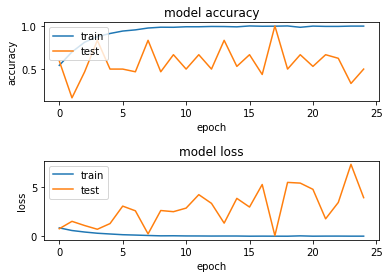

In [8]:
'''
plot training and validation loss and accuracy history
'''

import matplotlib.pyplot as plt  

fig = plt.figure(1)  
fig.subplots_adjust(hspace=.75)

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  


# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

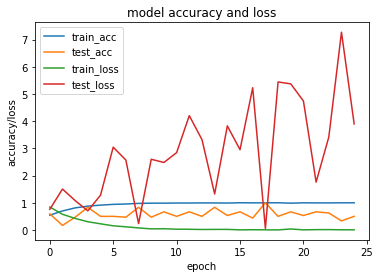

In [9]:
'''
plot training and validation loss and accuracy history
'''

import matplotlib.pyplot as plt  

fig = plt.figure(1)  
#fig.subplots_adjust(hspace=.75)

# summarize history for accuracy  
#plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc']) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss']) 

plt.title('model accuracy and loss')  
plt.ylabel('accuracy/loss')  
plt.xlabel('epoch')  
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss' ], loc='upper left')  

